# Tutorial on k-means clustering

In this tutorial, we'll first go over what $k$-means clustering is, implement an algorithm to perform the clustering, run it with a simple set to further understand how the algorithm works, and then use it to compress an image. 

## Introduction
$k$-means clustering is used to partition $n$ data points into $k$ groups, or clusters (with necessarily $k ≤ n$). This is done by establishing $k$-many means and associating each data point with the closest mean. This problem is NP-hard, which means, informally, that the optimal solution cannot be found in polynomial time. However, locally optimal solutions can be found using approximate heuristic algorithms that are much more efficient.

Formally, we want to find the set, $S$, of $k$-many points that minimize the distance between each point in $S_i$ and its respective mean, $\mu_i$, for a given set of $n$ data points
$$\underset{S}{\text{arg min}} \sum_{i=1}^{k} \sum_{x \in S_i} ||x-\mu_i||^2$$

Most $k$-means clustering algorithms have three main steps: initialize, assignment, and update. 

The goal of the initialize step is to create the $k$-many means. This step will vary depending on the specific algorithm and implementation. For example, one of the more popular options is to choose the $k$ points randomly from the $n$ observations, while another option is to pick the first $k$ observations in the data set. Since the hueristic algorithms are only proven to provide local minimums, $k$-means clustering is usually run a number of times with different starting points so the specifics intialize step are not too important, as long as the initial means are within a reasonable distance of the given data.

Both the assignment and updates steps are much more important to the outcome of the clustering. Once the initialize step is run, the standard algorithm for clustering will alternate between assigning and updating until the position of the means no longer changes (i.e., the algorithm has converged on a solution). The assignment step associates each data point with the "closest" mean (i.e., the mean that minimizes the sum of squares). Next, the update step recomputes the position of each of the $k$ means to be the centroid (i.e., average position of all the points) of the set of points associated with that mean (as computed in the assignment step).

## Implementing k-means in Python
We'll begin by implementing $k$-means clustering in Python and applying the algorithm to a simple 2-dimensional data set to see how it works. 

First, we'll need to import the necessary modules: numpy, defaultdict, and matplotlib.

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
# Use SVG backend for better quality
%matplotlib inline

Next, we'll write a function that does the initialize step. In this implementation, we'll pick $k$ random data points (with uniform probability).

In [2]:
def initialize(P, k):
    """
    Returns k randomly chosen elements from data
    Input:
        P (array) : array of length n >= k
        k (int) : number of elements to return
    Output:
        initial_means (array) : k elements from P
    Raises:
        ValueError if k > len(data)
    """
    if k > len(P): raise ValueError("k={} must be less than or equal to len(P)={}".format(k, len(P)))
    # Returns k randomly selected items from P
    return np.random.permutation(P)[:k]

Now that we can get our initial $k$ means, we can work on the assignment step. Remember that this step is responsible for associating each data point with a mean. We'll split up this step into a few functions to make the code more readble and easier to debug. First, let's assume we're looking at a specific data point, $p$, and we want to find from the set of means, $S$, the closest mean, $\mu$, to it as defined by the distance function, `dist`. Allowing the user to pass in a `dist` function allows the algorithm to be generalied to $d$-dimensional data.

In [3]:
def find_closest_mean(p, S, dist):
    """
    Returns the index of the closest mean to p by find the minimum distance as defined by dist.
    If there are multiple occurences of the minimum value, returns the first occurence.
    Input:
        p : a single data point
        S (array) : array of means
        dist (callable) : function with that computes the distance between two points 
                          def dist(p1, p2) => float
    Output:
        i (int) : index of the closest mean to p
    """
    dist = map(lambda mu: dist(p, mu), S)
    return np.argmin(dist)

With this function in place, it's easy to find the closest means for the set of points, $P$, by mapping over them.

In [4]:
def find_closest_means(P, S, dist):
    """
    Returns the indexes of the closest means for each point in P
    Input:
        P (array) : array of data points
        S (array) : array of means
        dist (callable) : function with that computes the distance between two points 
                          def dist(p1, p2) => float
    Output:
        M (int array) : indexes of the closest means to each point in P
    """
    return map(lambda p: find_closest_mean(p, S, dist), P)

The next step is to write a function that assigns each point to the index of the mean in a dictionary (which has better performance when indexing into than a list). Given a list of points, $P$, the list of means, $S$, and a distance function, `dist`, we can find the closest mean for each point in $P$. We will create a zipped list of points and means to make it easy to associate points and means in our next step.

In [5]:
def assign(P, S, dist):
    """
    Returns a dictionary where the keys are the indices for the means and the values are lists of points 
    whose closest mean was the mean
    Input:
        P (array) : array of data points
        S (array) : array of means
    Returns:
        D (array) : index of mean and its associated cluster of points
    """
    M = find_closest_means(P, S, dist)
    return zip(P, M)

Okay, now our assignment step is finished; given a list of data and a list of means, we can assign each data point to the closest mean. Next, we'll work on writing code for the update step.

We'll start with writing a function that can compute the average point of a list of points. All we need to do is sum up all the points and then divide by the length of the list of points. Since we don't know how $d$-dimensional data should be added and divided, we allow the user to specify this with the `add` and `divide` functions. We can add up all of the points in $P$, using a `reduce`, and then call the custom `divide` function with this result and the number of points to get the average point.

In [6]:
def calculate_average_point(P, add, divide):
    """
    Returns the average point of the list of points, P
    Input:
        P (array) : array of data points
        add (callable) : function that adds two points together to a third point
                         def avg(p1, p2) => p_add
        divide (callable) : function that divides a point by a float (the length of the list)
                            def divide(p, l) => p'
    Output:
        p_avg : average point of all points in list
    """
    return divide(reduce(add, P), float(len(P)))

Well that was easy!

Now, all we need to do is to update the means by finding the average point for each list in the assignment dictionary. We will first create a dictionary that maps each mean to a list of points (i.e., the cluster for the $i$th mean). Then, for each cluster, we'll calculate the updated average point and add this to our array of updated means.

In [7]:
def update(D, add, divide):
    """
    Returns a list of new means based on the assignment dictionary D
    Input:
        D (array) : Array of points and their associated closest means
        add (callable) : function that adds two points together to a third point
                         def avg(p1, p2) => p_add
        divide (callable) : function that divides a point by a float (the length of the list)
                            def divide(p, l) => p'
    Ouput:
        S_ (array) : Array of updated means
    """
    S_ = []
    D_ = defaultdict(list)
    # Associate each mean with a list of points
    for j in xrange(len(D)):
        p, i = D[j]
        D_[i].append(p)
    
    for (i, P) in D_.items():
        S_.insert(i, calculate_average_point(P, add, divide))
    return S_

The update step is finally complete! In fact, we've finished the initialize, assignment, and update steps. Now, all we need to do is wrap these all into a pretty package that users can easily run. We'll let the user pass in their data and $k$, the number of clusters they want the algorithm to create (and, of course, the custom functions the user needs to define: `dist`, `add`, and `divide`). Just like the description of the algorithm in the introduction, we'll first initialize the means, and then switch between assigning and updating until the means stabilize. In this simple implementation, we'll define stabilization as just a max iteration count, but it could be any definition, such as the values being within a certain $\epsilon$ of the prior value.

In [8]:
def k_means_cluster(P, k, dist, add, divide, max_iterations=10, epsilon=1e-6):
    S = initialize(P, k)
    for i in xrange(max_iterations):
        D = assign(P, S, dist)
        S = update(D, add, divide)
    return D, S

## Clustering (x,y) points

This has all been rather esoteric so let's make this more understandable by looking at $k$-means clustering on a 2D data set. First, we'll have to define `dist`, `add`, and `divide` for our data. We'll use the classic Euclidian distance as our definition for `dist`, and `add` and `divide` on each coordinate separately.

In [9]:
# Returns the Euclidian distance between two (x, y) points
def dist2((x1, y1), (x2, y2)):
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

# Adds two (x, y) points coordinate-wise
def sum2 ((x1, y1), (x2, y2)): 
    return (x1 + x2, y1 + y2)

# Dvides two (x, y) points by l coordinate-wise
def div2 ((x, y), l): 
    return (x / l, y / l)

Now that we have our definition of these operations, we can create a simple data set to see how the clustering algorithm works. Let's consider the following data:
$$P = [(0, 0), (1, 1), (0, 1), (1, 0), (4, 3), (3, 4), (6, 1), (5, 4)]$$

Let's first plot the data so we have an idea of what it looks like. Plotting the data before running $k$-means clustering allows us to get an intutition for the data.

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


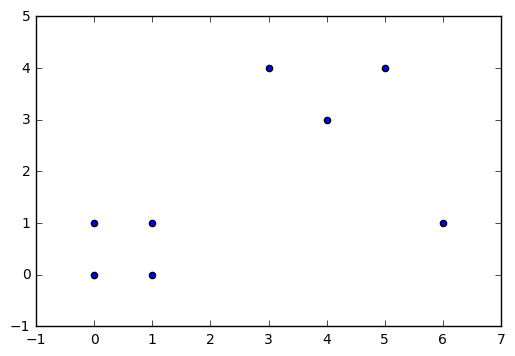

In [10]:
x = [0, 1, 0, 1, 4, 3, 6, 5]
y = [0, 1, 1, 0, 3, 4, 1, 4]
plt.scatter(x, y)

Just from plotting the data, it's easy to see that there could be two or three well-defined clusters between the upper right and lower left. So, we'll try running the algorithm with $k = 2$ and $k = 3$ and see how the results compare.

The algorithm returns a slightly inconvenient form of the clusters for plotting, so we'll define a helper function that takes in the results of the algorithm and plots each cluster in its own color as well as the mean for that cluster.

In [11]:
def plot_k_means(P, S, colors={0: "r", 1: "g", 2: "b"}):
    """
    Plots a k-means result
    Input:
        P (array) : array of points
        S (callable) : array of means
        colors (dict) : dictionary of indexes and color codes
    Ouput:
        plt : plot object
    """
    # Unzips a list l
    def unzip(l):
        return [list(t) for t in zip(*l)]
    
    D = defaultdict(list)
    
    # For every point, create the cluster mapping from mean index to list points
    for j in xrange(len(P)):
        p, i = P[j]
        D[i].append(p)
    
    # For every cluster, plot the x and y points and the mean.
    for i in xrange(len(D)):
        cluster = unzip(D[i])
        x = cluster[0]
        y = cluster[1]
        mean = S[i]
        plt.scatter(x, y, c=colors[i], label="Cluster {}".format(i+1))
        plt.plot(mean[0], mean[1], color=colors[i], marker='x', linestyle="None", label="Cluster {} mean".format(i+1))
    plt.legend(numpoints=1, loc="best")
    return plt

First, we'll try with $k = 2$. 

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

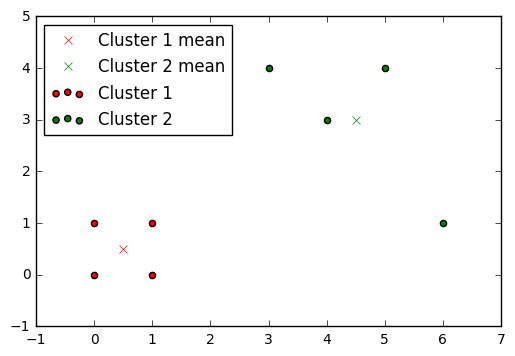

In [12]:
# Repeated just for reference
x = [0, 1, 0, 1, 4, 3, 6, 5]
y = [0, 1, 1, 0, 3, 4, 1, 4]

P, S = k_means_cluster(zip(x, y), 2, dist2, sum2, div2)
plot_k_means(P, S)

Running this dataset through the the clustering algorithm splits up the data where you think it would: top right and bottom left. In fact, even though the starting points for the means are random, the final means are actually always the same. This might suggest that $k = 2$ is a "good" number of clusters (i.e., the data always groups together the same way with just two groups).

Now we can try running it again with $k = 3$.

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

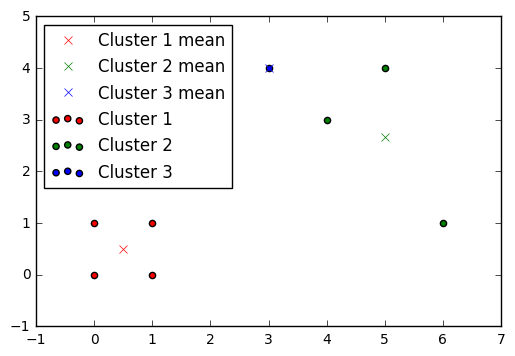

In [13]:
# Repeated just for reference
x = [0, 1, 0, 1, 4, 3, 6, 5]
y = [0, 1, 1, 0, 3, 4, 1, 4]

D, S = k_means_cluster(zip(x, y), 3, dist2, sum2, div2)
plot_k_means(D, S)

This time, with $k = 3$, running the algorithm multiple times will result in different clusters. The bottom left always seems to be grouped together in the pack of four (although occasionally, the four will be split into two groups of two either vertically or horizontally). The top right has much more variation in how it gets clustered. Sometimes, the furthest right point (6, 2) will be in its own cluster, while other times the further left gets its own cluster. 

This variation in clusters might suggest, opposite of before, that $k = 3$ is not a great way of clustering the data. Of course, this variation is affected by the initial mean points, so maybe it also suggests that the way we are picking the initial means is not optimal.

## Image Compression

Now that we have an idea of what $k$-means clustering is doing, and how its doing it, we can apply the principles to an image.

We can represent an image as a matrix (2d array) of pixels (three-tuples of `(r,g,b)`). The idea is that we can find a smaller number of representative colors, and map the original information to a lower-dimensional color space using the given clusters.

We'll have to flatten the image in order to run $k$-means on it, but other than that, the process should be just as simple as before. We'll start by defining our `dist`, `add`, and `div` functions. We can define the distance between two pixels (in color space) as the 3D Euclidian distance between two points. Similarly, `add` and `div` will be color-wise so that the red, green, and blue channels are kept separate.

In [14]:
def dist_pixel((r1, g1, b1), (r2, g2, b2)):
    return ((r1 - r2)**2 + (g1 - g2)**2 + (b1 - b2)**2)**0.5

def add_pixel((r1, g1, b1), (r2, g2, b2)):
    return (r1 + r2, g1 + g2, b1 + b2)

def div_pixel((r, g, b), l):
    return (r / l, g / l, b / l)

Now that we have our necessary functions, we'll need to load the image data and flatten the matrix into a list. We'll need to import the misc library from scipy in order to load the pixel data into our program.

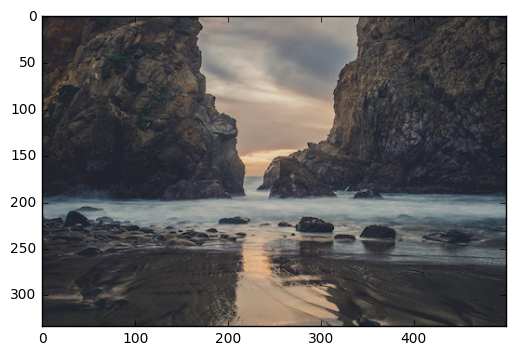

In [15]:
from scipy import misc

def load_image(filepath):
    image = misc.imread(filepath)
    return image

# Load the iamge
image = load_image("img1.jpeg")
plt.imshow(image)

With our list of `pixels` and the dimensions of the image, we can run the image data through our algorithm for different values of $k$ and see how the image compression works.

Let's run the clustering algorithm for $k = 3$, $k = 6$, and $k = 20$.

In [16]:
def compress_image(image, k):
    image = image.astype(float)
    (height, width, d) = image.shape
    pixels = np.reshape(image, (height * width, d))
    D, S = k_means_cluster(pixels, k, dist_pixel, add_pixel, div_pixel)
    x = map(lambda (p, i): S[i], D)
    compressed_pixels = np.reshape(x, (height, width, d))
    compressed_image = misc.toimage(compressed_pixels)
    return compressed_image

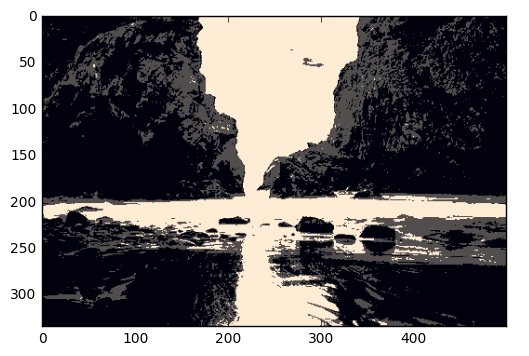

In [17]:
# Compress image with k = 3
image3 = compress_image(image, 3)
plt.imshow(image3)

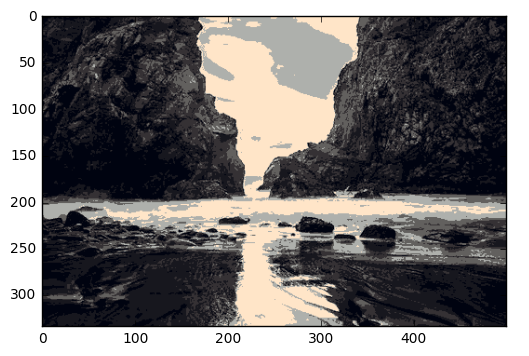

In [18]:
# Compress image with k = 6
image6 = compress_image(image, 6)
plt.imshow(image6)

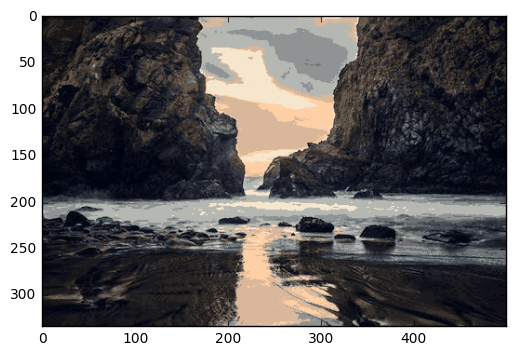

In [19]:
# Compress image with k = 20 (should take about 3 minutes)
image20 = compress_image(image, 20)
plt.imshow(image20)

We can also run this compression algorithm on images of faces to see how a portrait rendered in fewer colors works. We can go ahead and load two portraits and compress them using $k = 6$.

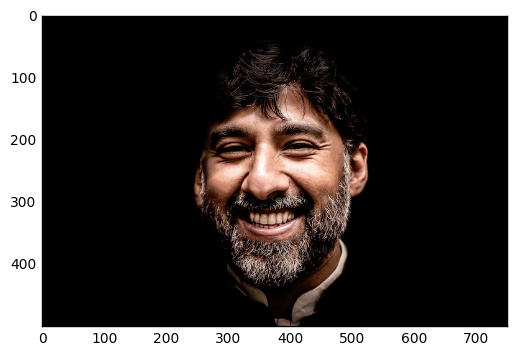

In [20]:
# Load the first portrait
portrait1 = load_image("portrait1.jpeg")
plt.imshow(portrait1)

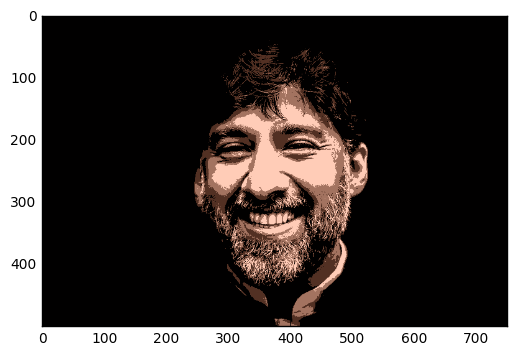

In [21]:
# Compress the first portrait
portrait1_compressed = compress_image(portrait1, 6)
plt.imshow(portrait1_compressed)

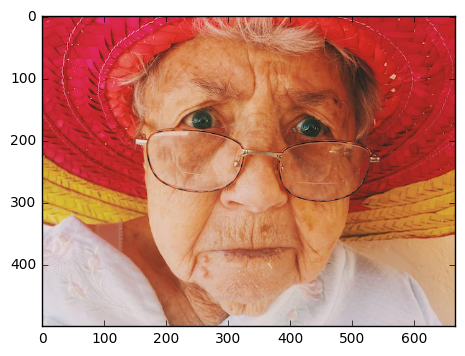

In [22]:
# Load the second portrait
portrait2 = load_image("portrait2.jpeg")
plt.imshow(portrait2)

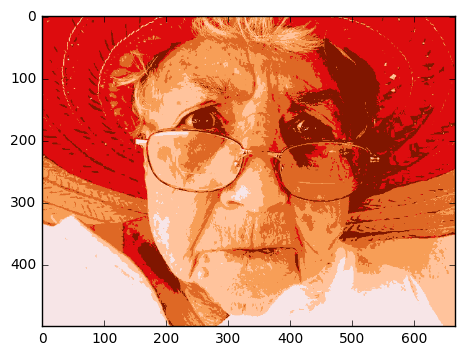

In [23]:
# Compress the second portrait
portrait2_compressed = compress_image(portrait2, 6)
plt.imshow(portrait2_compressed)

We've approached the $k$-means problem very mathematically. You'll notice that the code is rather simple and extensible. However, this simplicity comes at the expense of performance and taking advantage of assumptions we can make when running $k$-means on large datasets. Generally, you will be working with numpy arrays. As a result, functions like `dist` can be vastly improved by using `scipy.spatial.distance.cdist` for most datasets and applying the function over the entire array at once instead of each element, which speeds up the clustering algorithm considerably. As a good excercise, try rewriting the algorithm to take advantage of numpy arrays specifically for the application of the `dist` function. Focus on rewriting `find_closest_mean` and `find_closest_means` to not use a map, but rather to call `dist` with the entire array of data points and having the user-defined `dist` function accept the entire array rather than a single point. For a reference solution, check below for an idea of how to start this process.

In [24]:
# Import the distance module from scipy
from scipy.spatial import distance

# Note that we don't even use `find_closest_mean` anymore and assume that the `dist`
# function will take care of this and return the entire M array of closest means
def find_closest_means(P, S, dist):
    """
    Returns the indexes of the closest means for each point in P
    Input:
        P (array) : array of data points
        S (array) : array of means
        dist (callable) : function with that returns the list of closest means
                          def dist(P, S) => M
    Output:
        M (int array) : indexes of the closest means to each point in P
    """
    return dist(P, S)

def dist(P, S):
    """
    Returns the indexes of the closest mean for each point in P
    Input:
        P (array) : array of data points
        S (array) : array of means
    
    Output:
        M (int array) : indexes of closest means to each point in P
    """
    # Calculates distances between each pair of points
    distances = distance.cdist(P, S)
    # Finds the index of the smallest distance for each point
    return np.argmin(distances, axis=1)

In [ ]:
def test_intialize():
    data = [1, 0, 7, 4, 3, 6, 3]
    initial_means = initialize(data, 1)
    assert(len(initial_means) == 1)
    assert([mean in data for mean in initial_means])
    initial_means = initialize(data, 4)
    assert(len(initial_means) == 4)
    assert([mean in data for mean in initial_means])
    print "Passed test_initialize!"

def dist1(a, b):
    return abs(a - b)

def dist2((x1, y1), (x2, y2)):
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

def test_find_closest_mean():
    S1 = [1, 0, 2, 5, 3, 4.1]
    mu1 = find_closest_mean(1.3, S1, dist1)
    assert(mu1 == 0)
    mu1 = find_closest_mean(3.5, S1, dist1)
    assert(mu1 == 4)    
    S2 = [(0, 0), (1, 1), (0, 1), (1, 0), (4, 2), (3, 4)]
    mu2 = find_closest_mean((1, 2), S2, dist2)
    assert(mu2 == 1)
    mu2 = find_closest_mean((-1, -1), S2, dist2)
    assert(mu2 == 0)
    mu2 = find_closest_mean((3.5, 3), S2, dist2)
    assert(mu2 == 4)
    print "Passed test_find_closest_mean!"

def test_find_closest_means():
    P1 = [0, 4, 6, 7]
    S1 = [5, 3, 2, 4]
    M1 = find_closest_means(P1, S1, dist1)
    assert(M1 == [2, 3, 0, 0])
    P2 = [(0, 0), (1, 1), (0, 1), (1, 0), (4, 2), (3, 4)]
    S2 = [(1.5, 0), (1, 1.5), (0, 6.), (4.2, 1.3)]
    M2 = find_closest_means(P2, S2, dist2)
    assert(M2 == [0, 1, 1, 0, 3, 3])
    print "Passed test_find_closest_means!"

def test_assign():
    P1 = [0, 4, 6, 7]
    S1 = [5, 3, 2, 4]
    D1 = assign(P1, S1, dist1)
    assert(D1 == [(0, 2), (4, 3), (6, 0), (7, 0)])
    P2 = [(0, 0), (1, 1), (0, 1), (1, 0), (4, 2), (3, 4)]
    S2 = [(1.5, 0), (1, 1.5), (0, 6.), (4.2, 1.3)]
    D2 = assign(P2, S2, dist2)
    assert(D2 == [((0, 0), 0), ((1, 1), 1), ((0, 1), 1), ((1, 0), 0), ((4, 2), 3), ((3, 4), 3)])
    print "Passed test_assign!"

def sum1 (a, b):
    return a + b

def div1 (p, l):
    return p / l

def sum2 ((x1, y1), (x2, y2)): 
    return (x1 + x2, y1 + y2)

def div2 ((x, y), l): 
    return (x / l, y / l)

def test_calculate_average_point():
    data1 = [1., 0., 7., 4., 3., 6., 3.]
    p_avg1 = calculate_average_point(data1, sum1, div1)
    assert(p_avg1 == sum(data1) / float(len(data1)))
    data2 = [(0, 0), (1, 1), (0, 1), (1, 0), (4, 2), (3, 4)]
    p_avg2 = calculate_average_point(data2, sum2, div2)
    assert(p_avg2 == (3/2., 4/3.))
    print "Passed test_calculate_average_point!"

def test_update():
    P1 = [0, 4, 6, 7]
    S1 = [5, 3, 2, 4]
    D1 = assign(P1, S1, dist1)
    S1_updated = update(D1, sum1, div1)
    assert(S1_updated == [6.5, 0., 4.])
    P2 = [(0, 0), (1, 1), (0, 1), (1, 0), (4, 2), (3, 4)]
    S2 = [(1.5, 0), (1, 1.5), (0, 6.), (4.2, 1.3)]
    D2 = assign(P2, S2, dist2)
    S2_updated = update(D2, sum2, div2)
    assert(S2_updated == [(0.5, 0.), (0.5, 1.), (3.5, 3)])
    print "Passed test_update()!"

def test():
    # Tests won't pass since we overwrote the find_closest_means functions,
    # but they would if you commented out the override
    test_intialize()
    test_find_closest_mean()
    test_find_closest_means()
    test_assign()
    test_calculate_average_point()
    test_update()
    print "Passed all tests!"